In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
full_train=pd.read_csv('/Users/vinayswamy/Downloads/creditcard.csv')


In [4]:
full_train.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
train_subset=full_train.rename(columns={'Class':'target'})

First pass, we're lazy and don't look at the data, and start training models

In [7]:
# id and target not need for features df

X=train_subset.drop(columns=['target'])
Y=train_subset['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1,stratify=Y)

In [8]:
Y_train.shape

(227845,)

In [9]:
model=LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [10]:
Y_pred=model.predict(X_test)
Y_score=model.predict_proba(X_test)[:,1]
acc=metrics.accuracy_score(Y_test, Y_pred)
print(acc*100)
    

99.90871107053826


Looks a little too good to me 

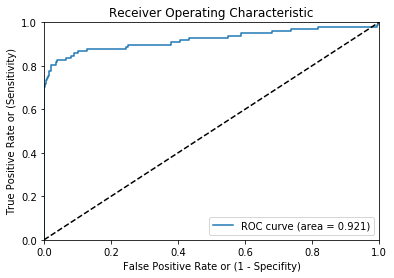

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_score)
roc_auc = metrics.roc_auc_score(Y_test, Y_score)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

Still looks good. Let look at some actual numbers A confusion matrix is a good way evaluate models

In [12]:
conf_mat = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print('Confusion matrix: LogReg\n', conf_mat)

Confusion matrix: LogReg
 [[56844    20]
 [   32    66]]


We're missing a bunch of the stuff

Precision-Recall plots are another way to evaluate model accuracy

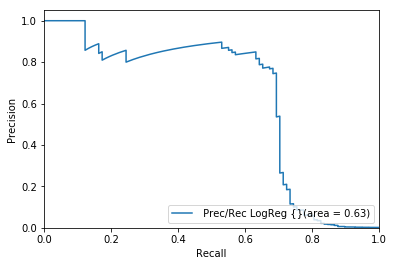

In [13]:
plt.figure()
pre, rec, thresholds = metrics.precision_recall_curve(Y_test, Y_score)
auc = metrics.average_precision_score(Y_test, Y_score)
plt.plot(rec, pre, label=' Prec/Rec LogReg {}(area = %0.2f)' % ( auc))
plt.plot([1, 1], [1, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc="lower right")
plt.show()

Not as good as we thought. Lets look more at the data.

In [14]:
train_subset.target.value_counts()

0    284315
1       492
Name: target, dtype: int64

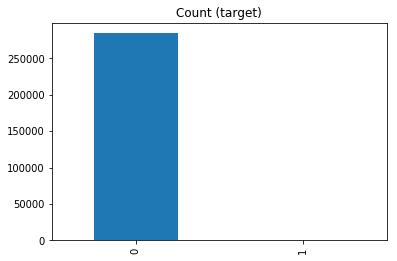

In [15]:
train_subset.target.value_counts().plot(kind='bar', title='Count (target)')

This data is super imabalanced. When models are trained on imbalanced data, the most probable choice for each prediction will always be class with the higher proportion.


One simple solution to this problem would be to just balance the data manual, and sampling evenly from each class. The imblearn module provides a convient method to sample data


!pip install -U imbalanced-learn

FYI - don't use conda, it looks like the module is out of date
A simple way to sample the data might be to select the class with the lowest number of members and samples thatg amout from the rest of the classes. This is known as undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler()
X_underSample, Y_underSample= rus.fit_sample(X_train, Y_train)


X_underSample.shape

(788, 30)

It's important to always resample from the training, and test on the imbalanced data

In [17]:
model.fit(X_underSample, Y_underSample)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
Y_pred=model.predict(X_test)
Y_score=model.predict_proba(X_test)[:,1]
conf_mat = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print('Confusion matrix: confmat', conf_mat)

Confusion matrix: confmat [[54725  2139]
 [    7    91]]


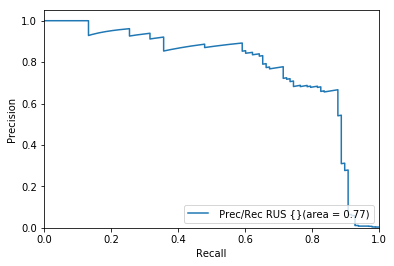

In [19]:
plt.figure()
pre, rec, thresholds = metrics.precision_recall_curve(Y_test, Y_score)
auc = metrics.average_precision_score(Y_test, Y_score)
plt.plot(rec, pre, label=' Prec/Rec RUS {}(area = %0.2f)' % ( auc))
plt.plot([1, 1], [1, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc="lower right")
plt.show()

In [20]:
from imblearn.over_sampling import RandomOverSampler
ROS=RandomOverSampler()
X_ROS, Y_ROS = ROS.fit_sample(X_train, Y_train)
X_ROS.shape

(454902, 30)

In [ ]:
model.fit(X_ROS, Y_ROS)

In [ ]:
Y_pred=model.predict(X_test)
conf_mat = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print('Confusion matrix: LogReg-ROS\n', conf_mat)

In [ ]:
plt.figure()
Y_pred=model.predict(X_test)
Y_scores= model.predict_proba(X_test)[:,1]
pre, rec, thresholds = metrics.precision_recall_curve(Y_test, Y_scores)
auc = metrics.average_precision_score(Y_test, Y_scores)
plt.plot(rec, pre, label=' Prec/Rec RUS logReg-RUS(area = %0.2f)' % ( auc))
plt.plot([1, 1], [1, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc="lower right")
plt.show()

In [21]:
from imblearn.over_sampling import SMOTE
sm=SMOTE()
X_sm, Y_sm = sm.fit_sample(X_train, Y_train)
X_sm.shape

(454902, 30)

In [22]:
model.fit(X_sm, Y_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
Y_pred=model.predict(X_test)
conf_mat = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print('Confusion matrix: LogReg-SMOTE', conf_mat)

In [ ]:

plt.figure()
Y_pred=model.predict(X_test)
Y_scores= model.predict_proba(X_test)[:,1]
pre, rec, thresholds = metrics.precision_recall_curve(Y_test, Y_scores)
auc = metrics.average_precision_score(Y_test, Y_scores)
plt.plot(rec, pre, label=' Prec/Rec LogReg-SMOTE(area = %0.2f)' % ( auc))
plt.plot([1, 1], [1, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc="lower right")
plt.show()


This is worse than the model on the original data; This is because SMOTE has a couple hyper parameters that we can fiddle with 

In [ ]:
import warnings
from sklearn.model_selection import GridSearchCV
import numpy as np
from imblearn.pipeline import make_pipeline
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
pipe = make_pipeline(
    SMOTE(),
    LogisticRegression()
)


weights = np.linspace(0.6, 1, 10)
#weights=['minority','not minority']


gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        #'smote__ratio': [{0: int(num_neg), 1: int(num_neg * w) } for w in weights]
        'smote__sampling_strategy': weights
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X, Y)

print("Best parameters : %s" % grid_result.best_params_)

In [ ]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(sampling_strategy=0.6)
X_sm, Y_sm = sm.fit_sample(X_train, Y_train)
X_sm.shape

In [ ]:
sm=SMOTE()
X_sm, Y_sm = sm.fit_sample(X_train, Y_train)
X_sm.shape
model.fit(X_sm, Y_sm)


In [ ]:
plt.figure()
Y_pred=model.predict(X_test)
Y_scores= model.predict_proba(X_test)[:,1]
pre, rec, thresholds = metrics.precision_recall_curve(Y_test, Y_scores)
auc = metrics.average_precision_score(Y_test, Y_scores)
plt.plot(rec, pre, label=' Prec/Rec LogReg-SMOTE(area = %0.2f)' % ( auc))
plt.plot([1, 1], [1, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc="lower right")
plt.show()

You can also change the class weights. the balanced option attempts to change weights so each penalization creates an even split between classes

In [ ]:
model = LogisticRegression(class_weight='balanced')

# Fit..
model.fit(X_train, y_train)


In [ ]:
Y_pred=model.predict(X_test)
conf_mat = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
print('Confusion matrix: LogReg-SMOTE', conf_mat)
plt.figure()
Y_pred=model.predict(X_test)
Y_scores= model.predict_proba(X_test)[:,1]
pre, rec, thresholds = metrics.precision_recall_curve(Y_test, Y_scores)
auc = metrics.average_precision_score(Y_test, Y_scores)
plt.plot(rec, pre, label=' Prec/Rec LogReg-SMOTE(area = %0.2f)' % ( auc))
plt.plot([1, 1], [1, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')